In [1]:
!pip3 install pandas matplotlib  geopandas descartes 
!pip3 install shifterator wordcloud gensim nltk networkx

In [58]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from wordcloud import WordCloud
from gensim import corpora, models
import geopandas as gpd
import shifterator as sh
import nltk
from nltk.corpus import stopwords
import networkx as nx

In [3]:
tweets = pd.read_csv("http://cssbook.net/d/covid.csv")
tweets.head()

,status_id,created_at,screen_name,lang,location,text,retweet_count,reply_to_screen_name
0,1309535775109926912,2020-09-25T16:50:33Z,ghulamabbasshah,en,"Lahore, Pakistan",Secularism of #Gandhi and #Nehru in #India has...,1203,NaN
1,1309626010221129729,2020-09-25T22:49:07Z,GeoRebekah,en,"Florida, USA",On the day @GovRonDeSantis rejects the experts...,1146,NaN
2,1309578234007257088,2020-09-25T19:39:16Z,AlexBerenson,en,New York,Updated @cgcgov figures: 66 children under 15 ...,988,NaN
3,1309557875296083969,2020-09-25T18:18:22Z,AlexBerenson,en,New York,No mo ro in Flo: @govrondesantis proves again ...,953,NaN
4,1309643186827132929,2020-09-25T23:57:22Z,B52Malmet,en,"New York, NY",Dr. Fauci warns the worst public health crisis...,946,NaN


<AxesSubplot:xlabel='created_at'>

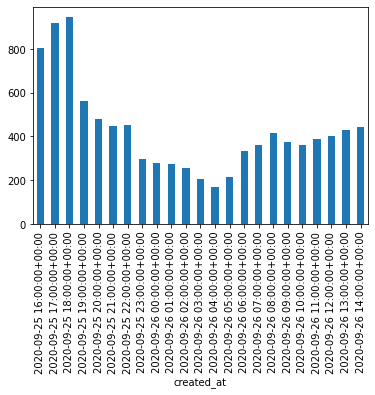

In [4]:
tweets.index = pd.DatetimeIndex(tweets['created_at'])
tweets['status_id'].groupby(pd.Grouper(freq='H')).count().plot(kind='bar')

(-0.5, 399.5, 199.5, -0.5)

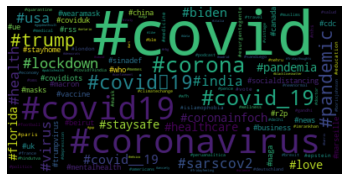

In [5]:
mycounter = defaultdict(int)
for tweet in tweets['text']:
    for hashtag in re.findall("#\w+", tweet):
            mycounter[hashtag.lower()]+=1
mywordcloud = WordCloud().generate_from_frequencies(mycounter)
plt.imshow(mywordcloud, interpolation='bilinear')
plt.axis("off")

In [6]:
hashtags = [[hashtag.lower() for hashtag in re.findall("#\w+", tweet)] for tweet in tweets['text']]
id2word = corpora.Dictionary(hashtags)
mycorpus = [id2word.doc2bow(doc) for doc in hashtags]
mymodel = models.LdaModel(mycorpus, id2word=id2word, num_topics=10, distributed=False, random_state=123)
mymodel.print_topics()

[(0,
  '0.030*"#coviduk" + 0.019*"#covid" + 0.010*"#lockdown2" + 0.007*"#police" + 0.006*"#crisis" + 0.005*"#dengue" + 0.004*"#portland" + 0.004*"#durango" + 0.004*"#salerno" + 0.003*"#politica"'),
 (1,
  '0.132*"#covid" + 0.016*"#salud" + 0.012*"#blm" + 0.008*"#fridayvibes" + 0.006*"#africa" + 0.006*"#safety" + 0.005*"#sugar" + 0.005*"#ethanol" + 0.005*"#francia" + 0.005*"#rbob"'),
 (2,
  '0.105*"#covid" + 0.030*"#vaccine" + 0.029*"#lockdown" + 0.014*"#quarantine" + 0.008*"#campania" + 0.007*"#sports" + 0.007*"#economy" + 0.007*"#unga" + 0.006*"#unemployment" + 0.006*"#covidtesting"'),
 (3,
  '0.151*"#covid" + 0.112*"#covid19" + 0.067*"#coronavirus" + 0.048*"#covid_19" + 0.045*"#corona" + 0.023*"#covidー19" + 0.012*"#biden" + 0.010*"#sarscov2" + 0.009*"#covid__19" + 0.007*"#coronainfoch"'),
 (4,
  '0.664*"#covid" + 0.010*"#covidー19" + 0.005*"#covidiots" + 0.005*"#masks" + 0.004*"#cdc" + 0.004*"#covid19" + 0.004*"#podcast" + 0.003*"#marseille" + 0.003*"#nhs" + 0.003*"#youtube"'),
 (5,
 

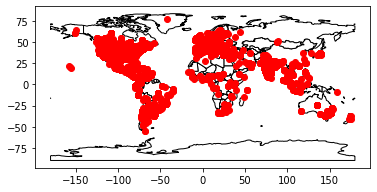

In [7]:
users = pd.read_csv("http://cssbook.net/d/covid_users.csv")
tweets = tweets.merge(users, on='screen_name', how='left')
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf = gpd.GeoDataFrame(tweets, geometry=gpd.points_from_xy(tweets.long, tweets.lat))
ax = world.plot(color='white', edgecolor='black')
gdf.plot(ax=ax, color='red')
plt.show()

[nltk_data] Downloading package stopwords to /home/damian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.8/dist-packages/shifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


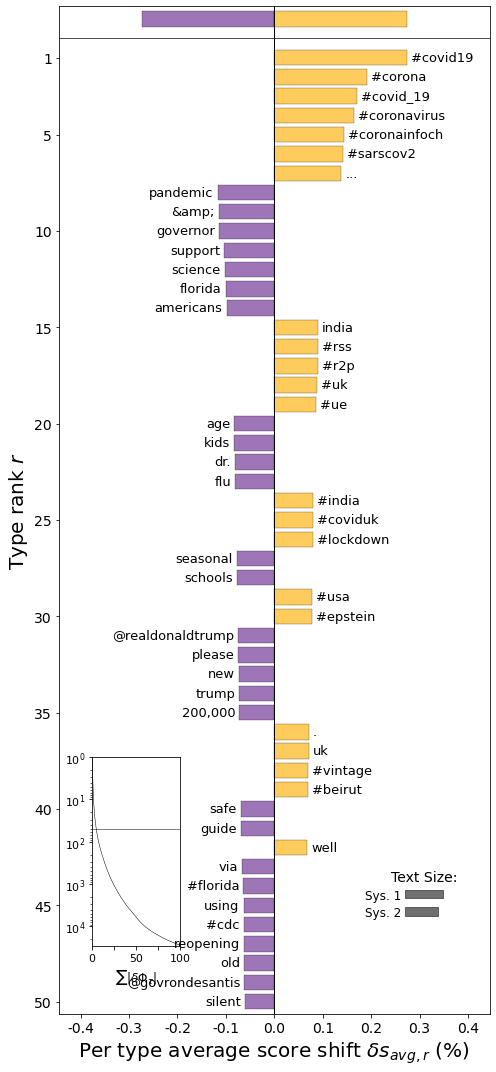

In [8]:
nltk.download('stopwords')
corpus_northamerica = gdf.query("lang=='en' & (long<-60 & lat>25)")['text'].str.cat()
corpus_rest = gdf.query("lang=='en' & (long>-60 | lat<25)")['text'].str.cat()
count_northamerica = Counter(corpus_northamerica.lower().split())
count_rest = Counter(corpus_rest.lower().split())
for k in stopwords.words('english'):
    del count_northamerica[k]
    del count_rest[k]
proportion_shift = sh.ProportionShift(type2freq_1=count_northamerica,
                                      type2freq_2=count_rest)
proportion_shift.get_shift_graph()

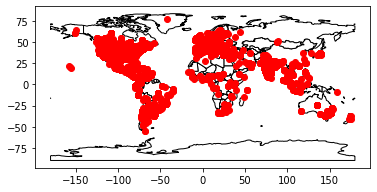

In [9]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf = gpd.GeoDataFrame(tweets, geometry=gpd.points_from_xy(tweets.long, tweets.lat))
ax = world.plot(color='white', edgecolor='black')
gdf.plot(ax=ax, color='red')
plt.show()

In [10]:
edges = tweets[['screen_name','reply_to_screen_name']].dropna().rename({'screen_name':'from', 'reply_to_screen_name':'to'}, axis='columns').groupby(['from','to'], as_index=False).size()
edges.head()

,from,to,size
0,007Vincentxxx,ilfattovideo,1
1,06CotedUsure,ArianeWalter,1
2,1Million4Covid,1Million4Covid,3
3,1Million4Covid,JustinTrudeau,1
4,1ctboy1,LegionPost13,1


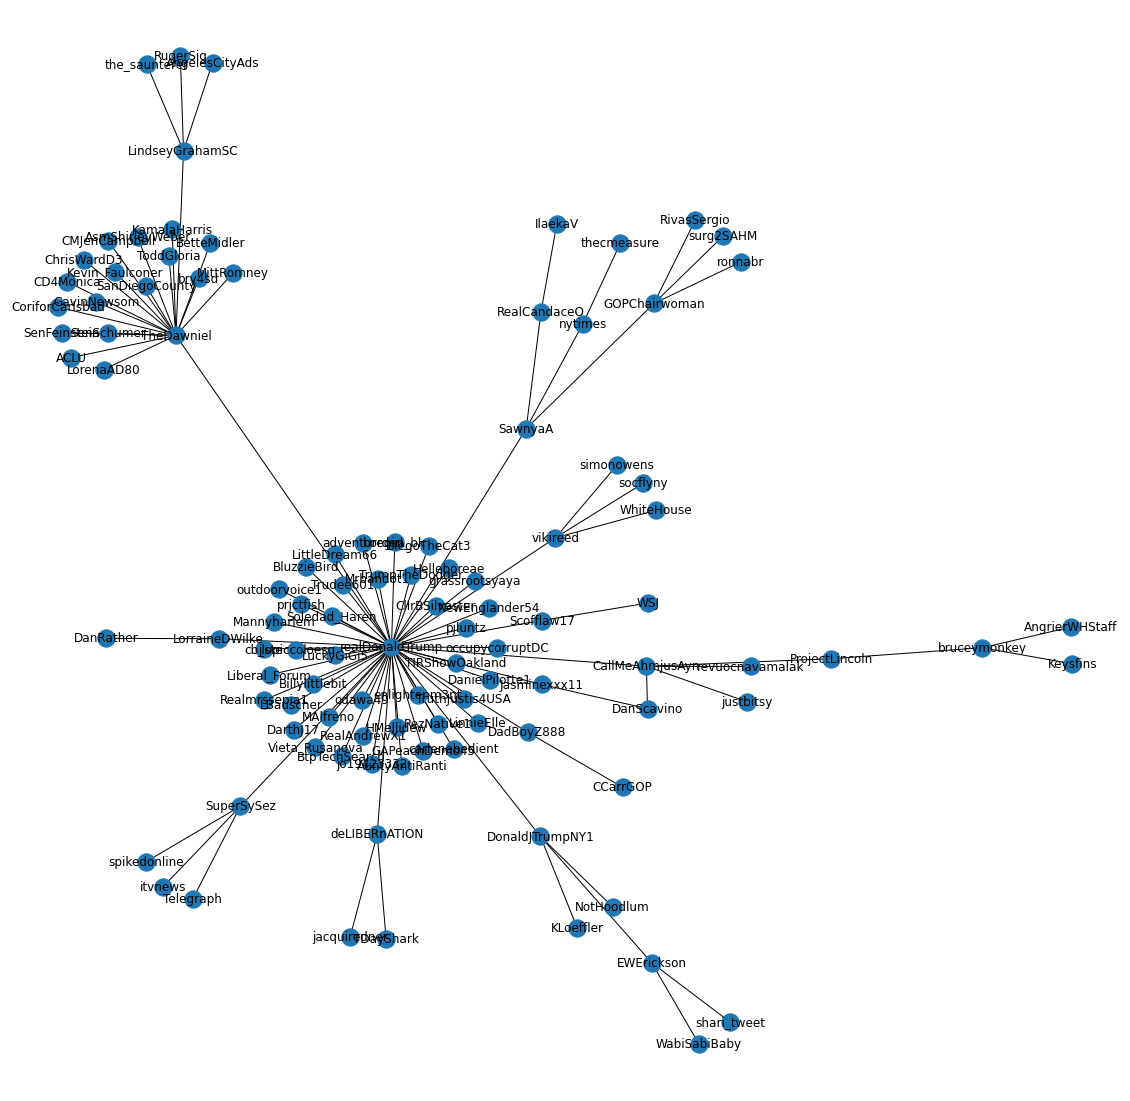

In [11]:
g1 = nx.Graph()
g1.add_edges_from(tweets[['screen_name','reply_to_screen_name']].dropna().rename({'screen_name':'from', 'reply_to_screen_name':'to'}, axis='columns').to_numpy())
largest_cc = max(nx.connected_components(g1), key=len)
g2 = g1.subgraph(largest_cc)

pos = nx.spring_layout(g2)
plt.figure(figsize=(20,20))
plt.axis("off")
nx.draw_networkx_nodes(g2,pos)
nx.draw_networkx_labels(g2,pos)
nx.draw_networkx_edges(g2,pos)


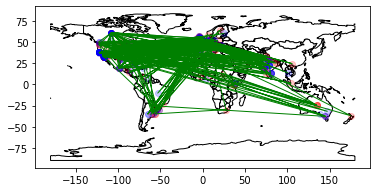

In [13]:
edges = tweets[['screen_name','reply_to_screen_name','retweet_count']].dropna().rename({'screen_name':'from', 'reply_to_screen_name':'to'}, axis='columns')
edges2 = edges.merge(users, left_on='from', right_on='screen_name').rename({'lat':'lat_from', 'long':'long_from'}, axis=1).drop(["screen_name","location"], axis=1)
edges2 = edges2.merge(users, left_on='to', right_on='screen_name').rename({'lat':'lat_to', 'long':'long_to'}, axis=1).drop(["screen_name","location"], axis=1)
edges2 = edges2.query("long_to!=long_from & lat_to!=lat_from").dropna()

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf_to = gpd.GeoDataFrame(edges2.copy(), geometry=gpd.points_from_xy(edges2.long_to, edges2.lat_to))
gdf_from = gpd.GeoDataFrame(edges2.copy(), geometry=gpd.points_from_xy(edges2.long_from, edges2.lat_from))

gdf_from['size']=gdf_from['retweet_count'].map(lambda x: (x+1)*50)
gdf_to['size']=gdf_from['retweet_count'].map(lambda x: (x+1)*50)

ax = world.plot(color='white', edgecolor='black', figsize=(10,10))
gdf_from.plot(ax=ax, color='red', alpha=.2, markersize='size')
gdf_to.plot(ax=ax, color='blue', alpha=.2, markersize='size')

edges3 = gdf_from.join(gdf_to, lsuffix='_from', rsuffix='_to')[['geometry_from', 'geometry_to']]
x_values = list(zip(edges3['geometry_from'].map(lambda point: point.x), edges3['geometry_to'].map(lambda point: point.x)))
y_values = list(zip(edges3['geometry_from'].map(lambda point: point.y), edges3['geometry_to'].map(lambda point: point.y)))
plt.plot(x_values, y_values, linewidth = 1, linestyle = "-", color = "green", alpha=.3)

plt.show()